## 인프런 2020년 새해 다짐 이벤트 댓글 분석
* https://www.inflearn.com/pages/newyear-event-20200102
* 영상 튜토리얼 : [댓글 수백 수천개 분석하기?! [1/5] 이벤트 데이터 크롤링 feat. 인프런 새해 다짐 이벤트 - YouTube](https://www.youtube.com/watch?v=OUSwQk79H8I&list=PLaTc2c6yEwmohRzCxWQqJ7Z9aqc-sQ5gC)

## 기획자나 마케터가 되어 이벤트 댓글을 분석해 보자!
### 내가 만약 수백 수천개의 댓글을 다 읽어봐야 한다면?
### 댓글 속에 제품에 대한 관심을 빈도수로 추출해야 한다면?
* 쇼핑몰에서 제품 관련 이벤트 진행시 어떤 제품을 고객이 선호하는지 알고 싶다면?
* 고객 DB와 연계할 수 있다면 이벤트 혹은 마케팅 세그먼트로 활용해 볼 수도 있지 않을까?

### 향후 마케팅이나 전략을 어떻게 세워야 할까?

## 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

%matplotlib inline
# 시각화 결과가 선명하게 표시되도록
%config InlineBackend.figure_format = 'retina'

## 시각화를 위한 한글폰트 설정

In [2]:
# Window 한글폰트 설정
# plt.rc("font", family="Malgun Gothic")
# Mac 한글폰트 설정
plt.rc("font", family="AppleGothic")
plt.rc('axes', unicode_minus=False)

## 크롤링한 파일 로드하기

In [3]:
df = pd.read_csv("inflearn-event.csv")
df.shape

(1907, 1)

In [4]:
df.head()

,text
0,CS를 전공하고 있는 학생입니다. 새해에는 자바와 관련된 지식을 보다 깊이있게 쌓아...
1,새해에는 새롭게. 웹 보안쪽으로 공부해보고싶습니다.
2,"몇년동안 바쁘게 달려오느라 습득하지 못한 기술들이 너무 많이 쌓였네요, \n올해는 ..."
3,'2020년 공부 목표'\n강의 수강을 통한 개인 역략 고도화 및 취업!!!\n#관...
4,'2020년 공부 목표'\n웹 프론트엔드 영역 자유롭게 구사하는 기술 보유하여 스스...


In [5]:
df.tail()

,text
1902,"작년 한해도 일이 바쁘다, 야근해서 힘들다는 핑계로 김영한님의 JPA 강의를 또 스..."
1903,저는 졸업을 1년 남기고 있는 컴퓨터공학과 학생입니다. 졸업 프로젝트로 웹/앱 개발...
1904,"에프터 이펙트를 써본 적은 있는데, 매번 기초만 배우다 말았어요. 이걸 할 줄 안다..."
1905,저번에 인프런에서 페이스북 마케팅 강의를 듣고 많은 도움을 받았습니다. 마케팅 업무...
1906,인프런 0호 팀원이에요!\n그동안 서비스 개발 때문에 js 를 많이 했었는데 앞으론...


## 데이터 전처리

### 네트워크 오류 등으로 발생한 중복 입력 값을 제거
* 빈도 수 중복을 방지하기 위해

In [6]:
print(df.shape)
df = df.drop_duplicates(["text"], keep="last")
print(df.shape)

(1907, 1)
(1875, 1)


### 원본은 따로 보존

In [7]:
# 전처리 전에 원본을 보존하기 위해 복사해 둠
df["origin_text"] = df["text"]
df.head()

,text,origin_text
0,CS를 전공하고 있는 학생입니다. 새해에는 자바와 관련된 지식을 보다 깊이있게 쌓아...,CS를 전공하고 있는 학생입니다. 새해에는 자바와 관련된 지식을 보다 깊이있게 쌓아...
1,새해에는 새롭게. 웹 보안쪽으로 공부해보고싶습니다.,새해에는 새롭게. 웹 보안쪽으로 공부해보고싶습니다.
2,"몇년동안 바쁘게 달려오느라 습득하지 못한 기술들이 너무 많이 쌓였네요, \n올해는 ...","몇년동안 바쁘게 달려오느라 습득하지 못한 기술들이 너무 많이 쌓였네요, \n올해는 ..."
3,'2020년 공부 목표'\n강의 수강을 통한 개인 역략 고도화 및 취업!!!\n#관...,'2020년 공부 목표'\n강의 수강을 통한 개인 역략 고도화 및 취업!!!\n#관...
4,'2020년 공부 목표'\n웹 프론트엔드 영역 자유롭게 구사하는 기술 보유하여 스스...,'2020년 공부 목표'\n웹 프론트엔드 영역 자유롭게 구사하는 기술 보유하여 스스...


### 소문자 변환

In [8]:
# 파이썬은 대소문자를 구분하기 때문에 데이터 필터링을 위해 대문자를 모두 소문자로 변경
df["text"] = df["text"].str.lower()

In [9]:
# 같은 의미의 단어를 하나로 통일 예) python => 파이썬
df["text"] = df["text"].str.replace(
    "python", "파이썬").str.replace(
    "pandas", "판다스").str.replace(
    "javascript", "자바스크립트").str.replace(
    "java", "자바").str.replace(
    "react", "리액트")

### 텍스트로 관심 강의 분리

In [10]:
df["course"] = df["text"].apply(lambda x: x.split("관심강의")[-1])
df["course"] = df["course"].apply(lambda x: x.split("관심 강의")[-1])
df["course"] = df["course"].apply(lambda x: x.split("관심 강좌")[-1])
df["course"] = df["course"].str.replace(":", "")
df["course"].head()

0                                더 자바, 코드를 조작하는 다양한 방법
1                         새해에는 새롭게. 웹 보안쪽으로 공부해보고싶습니다.
2    몇년동안 바쁘게 달려오느라 습득하지 못한 기술들이 너무 많이 쌓였네요, \n올해는 ...
3                                    데이터 분석가 되기 with r
4    '2020년 공부 목표'\n웹 프론트엔드 영역 자유롭게 구사하는 기술 보유하여 스스...
Name: course, dtype: object

In [11]:
df[["text", "course"]].head()

,text,course
0,cs를 전공하고 있는 학생입니다. 새해에는 자바와 관련된 지식을 보다 깊이있게 쌓아...,"더 자바, 코드를 조작하는 다양한 방법"
1,새해에는 새롭게. 웹 보안쪽으로 공부해보고싶습니다.,새해에는 새롭게. 웹 보안쪽으로 공부해보고싶습니다.
2,"몇년동안 바쁘게 달려오느라 습득하지 못한 기술들이 너무 많이 쌓였네요, \n올해는 ...","몇년동안 바쁘게 달려오느라 습득하지 못한 기술들이 너무 많이 쌓였네요, \n올해는 ..."
3,'2020년 공부 목표'\n강의 수강을 통한 개인 역략 고도화 및 취업!!!\n#관...,데이터 분석가 되기 with r
4,'2020년 공부 목표'\n웹 프론트엔드 영역 자유롭게 구사하는 기술 보유하여 스스...,'2020년 공부 목표'\n웹 프론트엔드 영역 자유롭게 구사하는 기술 보유하여 스스...


## 띄어 쓰기를 제거한 텍스트에서 키워드 추출
* TIOBE 프로그래밍 언어 순위 : [index | TIOBE - The Software Quality Company](https://www.tiobe.com/tiobe-index/?fbclid=IwAR34dJfgDHq2DK0C6X3g8IsUno2NhOiikMyxT6fw9SoyujFhy5FPvQogMoA)

In [12]:
search_keyword = ['머신러닝', '딥러닝', '파이썬', '판다스', '공공데이터',
                  'django', '크롤링', '시각화', '데이터분석', 
                  '웹개발', '엑셀', 'c', '자바', '자바스크립트', 
                  'node', 'vue', '리액트']

for keyword in search_keyword:
    df[keyword] = df["course"].str.contains(keyword)

In [13]:
df.head()

,text,origin_text,course,머신러닝,딥러닝,파이썬,판다스,공공데이터,django,크롤링,시각화,데이터분석,웹개발,엑셀,c,자바,자바스크립트,node,vue,리액트
0,cs를 전공하고 있는 학생입니다. 새해에는 자바와 관련된 지식을 보다 깊이있게 쌓아...,CS를 전공하고 있는 학생입니다. 새해에는 자바와 관련된 지식을 보다 깊이있게 쌓아...,"더 자바, 코드를 조작하는 다양한 방법",False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
1,새해에는 새롭게. 웹 보안쪽으로 공부해보고싶습니다.,새해에는 새롭게. 웹 보안쪽으로 공부해보고싶습니다.,새해에는 새롭게. 웹 보안쪽으로 공부해보고싶습니다.,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,"몇년동안 바쁘게 달려오느라 습득하지 못한 기술들이 너무 많이 쌓였네요, \n올해는 ...","몇년동안 바쁘게 달려오느라 습득하지 못한 기술들이 너무 많이 쌓였네요, \n올해는 ...","몇년동안 바쁘게 달려오느라 습득하지 못한 기술들이 너무 많이 쌓였네요, \n올해는 ...",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,'2020년 공부 목표'\n강의 수강을 통한 개인 역략 고도화 및 취업!!!\n#관...,'2020년 공부 목표'\n강의 수강을 통한 개인 역략 고도화 및 취업!!!\n#관...,데이터 분석가 되기 with r,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,'2020년 공부 목표'\n웹 프론트엔드 영역 자유롭게 구사하는 기술 보유하여 스스...,'2020년 공부 목표'\n웹 프론트엔드 영역 자유롭게 구사하는 기술 보유하여 스스...,'2020년 공부 목표'\n웹 프론트엔드 영역 자유롭게 구사하는 기술 보유하여 스스...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True


In [14]:
df_python = df[df["text"].str.contains("파이썬|공공데이터|판다스")].copy()
df_python.shape

(331, 20)

In [15]:
True + True + False

2

In [16]:
df[search_keyword].sum().sort_values(ascending=False)

파이썬       311
c         306
자바        263
머신러닝      110
자바스크립트    110
리액트       104
vue        98
node       94
딥러닝        44
크롤링        37
django     28
시각화        23
웹개발        22
데이터분석      22
엑셀         17
공공데이터       6
판다스         5
dtype: int64

In [17]:
text = df.loc[(df["공공데이터"] == True), "text"]
for t in text:
    print("-"*20)
    print(t)

--------------------
텍스트 마이닝만 수강한 뒤 현재 맡은 마케팅 업무 능률이 엄청나게 올라가는 것을 확인했으며 승진과 고가에 엄청나게 득을 보았습니다 감사합니다! 앞으로도 인프런 애용하겠습니다.
추가적으로 해 박조은 강사님의 [공공데이터로 파이썬 데이터 분석 시작하기] 강의를 듣고 상권분석과 공공데이터 활용 역량을 올릴 예정입니다. 화이팅!!!
#관심강의 : 공공데이터로 파이썬 데이터 분석 시작하기
--------------------
데이터분석 2년차가 되는데 작년에 파이썬 강의를 담아놓고 그대로 1년간 방치... 올해는 꼭 완강하고 실습해서 개발자에게 의존하지 않고 혼자 크롤링&분석 해내고 싶어요! 
#관심강의: 공공데이터로 파이썬 데이터분석 시작하기, database 1&2 - mysql
--------------------
2020년에는 데이터 분석쪽으로 이직하고 싶어요! 인프런 강의 듣고 이직에 성공하고 싶습니다!!
#관심강의: 공공데이터로 파이썬 데이터 분석 시작하기
--------------------
경영학과 졸업생입니다. 새해엔 엑셀! 파이썬! 취직! 해내겠습니다. 좋은 강의, 커리큘럼이 있는 인프런 너무 감사합니다 ~^^
#관심강의: 공공데이터로 분석하기
--------------------
인프런으로 파이썬 기초문법부터 입문했어요! 실무 데이터분석에 활용할 수 있는 수준으로 실력을 올리고 싶습니다:)
#관심강의: 공공데이터로 파이썬 데이터 분석 시작하기
--------------------
나만의 프로젝트 하나 완성할 수 있을 정도의 지식 쌓기!
#관심강의:공공데이터로 파이썬 데이터 분석 시작하기


## 판다스 단어가 들어가는 텍스트만 찾기
* 이미 str.contains 를 통해 판다스가 들어가는 텍스트에 대해 컬럼을 만들어 놨습니다. 이 값이  True 라면 판다스 강좌 입니다.

In [18]:
df.loc[df["판다스"] == True, "text"]

147     취미로 안드로이드 개발하는 사람입니다. 자바로 작성하다 보니, kotlin이 안드로...
215          판다스 라입러리에 관심이 많아서 배워보려 합니다 #관심강의 : 박조은 - 판다스
694       2020년!! 올 해는 빅데이터 분석 전문가 되기!!\n#관심강의 : 파이썬, 판다스
1613    2020년 목표  파이썬 을  활용해  데이터 분석 작업을 진행하고 싶습니다.  관...
1823    저는 백세시대에 조금 더 오랫동안 it일을 하기위해서 it전략기획에서 데이터분석가로...
Name: text, dtype: object

## 빈도수 계산을 위한 텍스트 데이터 벡터화
* BOW 단어 가방에 단어를 토큰화 해서 담아줌

In [19]:
# 토큰화
"파이썬 데이터 분석".split()

['파이썬', '데이터', '분석']

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = None, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋습니다. 
                             ngram_range=(3, 6), # BOW의 단위 갯수의 범위를 지정합니다.
                             max_features = 2000 # 만들 피처의 수, 단어의 수
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=2000, min_df=2,
                ngram_range=(3, 6), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [21]:
feature_vector = vectorizer.fit_transform(df['course'])
feature_vector.shape

(1875, 1935)

In [22]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

1935


['12개 만들면서 배우는',
 '12개 만들면서 배우는 ios',
 '12개 만들면서 배우는 ios 아이폰',
 '12개 만들면서 배우는 ios 아이폰 개발',
 '12개를 만들며 배우는',
 '12개를 만들며 배우는 swift4',
 '12개를 만들며 배우는 swift4 ios11',
 '12개를 만들며 배우는 swift4 ios11 아이폰',
 '2018 do it',
 '2018 do it 안드로이드']

In [23]:
# 각 리뷰마다 등장하는 단어에 빈도수가 표현됩니다. 0 은 등장하지 않음을 의미합니다.
pd.DataFrame(feature_vector[:10].toarray(), columns=vocab).head()

,12개 만들면서 배우는,12개 만들면서 배우는 ios,12개 만들면서 배우는 ios 아이폰,12개 만들면서 배우는 ios 아이폰 개발,12개를 만들며 배우는,12개를 만들며 배우는 swift4,12개를 만들며 배우는 swift4 ios11,12개를 만들며 배우는 swift4 ios11 아이폰,2018 do it,2018 do it 안드로이드,...,활용2 api 개발과 성능,활용2 api 개발과 성능 최적화,활용한 다양한 자동화,활용한 다양한 자동화 어플리케이션,활용한 다양한 자동화 어플리케이션 제작하기,활용한 데이터분석과 it보안,활용한 리액트 native,활용한 리액트 native 개발,활용한 메신져 만들기,활용한 메신져 만들기 android
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [24]:
# 위에서 구한 단어벡터를 더하면 단어가 전체에서 등장하는 횟수를 알 수 있습니다.
# 벡터화 된 피처를 확인해 봄
# Bag of words 에 몇 개의 단어가 들어있는지 확인
dist = np.sum(feature_vector, axis=0)
    
df_freq = pd.DataFrame(dist, columns=vocab)
df_freq

,12개 만들면서 배우는,12개 만들면서 배우는 ios,12개 만들면서 배우는 ios 아이폰,12개 만들면서 배우는 ios 아이폰 개발,12개를 만들며 배우는,12개를 만들며 배우는 swift4,12개를 만들며 배우는 swift4 ios11,12개를 만들며 배우는 swift4 ios11 아이폰,2018 do it,2018 do it 안드로이드,...,활용2 api 개발과 성능,활용2 api 개발과 성능 최적화,활용한 다양한 자동화,활용한 다양한 자동화 어플리케이션,활용한 다양한 자동화 어플리케이션 제작하기,활용한 데이터분석과 it보안,활용한 리액트 native,활용한 리액트 native 개발,활용한 메신져 만들기,활용한 메신져 만들기 android
0,2,2,2,2,2,2,2,2,2,2,...,9,9,7,7,6,2,7,7,2,2


In [25]:
# 행과 열의 축을 T로 바꿔주고 빈도수로 정렬
df_freq.T.sort_values(by=0, ascending=False).head(30)

,0
홍정모의 따라하며 배우는,71
스프링 데이터 jpa,46
머신러닝 완벽 가이드,45
파이썬 머신러닝 완벽,45
파이썬 머신러닝 완벽 가이드,44
2020년 공부 목표,43
nodebird sns 만들기,43
관심있는 인프런 강의명,38
리액트로 nodebird sns,36
리액트로 nodebird sns 만들기,36


In [26]:
df_freq_T = df_freq.T.reset_index()
df_freq_T.columns = ["course", "freq"]
# 강의명을 토큰 3개로 중복제거하기 위해, 강좌명에서 지식공유자의 이름을 빈문자열로 변경
df_freq_T["course_find"] = df_freq_T["course"].str.replace("홍정모의", "")
df_freq_T["course_find"] = df_freq_T["course_find"].apply(lambda x : " ". join(x.split()[:4]))
df_freq_T.sort_values(["course_find", "freq"], ascending=False).head(10)

,course,freq,course_find
1934,활용한 메신져 만들기 android,2,활용한 메신져 만들기 android
1933,활용한 메신져 만들기,2,활용한 메신져 만들기
1932,활용한 리액트 native 개발,7,활용한 리액트 native 개발
1931,활용한 리액트 native,7,활용한 리액트 native
1930,활용한 데이터분석과 it보안,2,활용한 데이터분석과 it보안
1928,활용한 다양한 자동화 어플리케이션,7,활용한 다양한 자동화 어플리케이션
1929,활용한 다양한 자동화 어플리케이션 제작하기,6,활용한 다양한 자동화 어플리케이션
1927,활용한 다양한 자동화,7,활용한 다양한 자동화
1925,활용2 api 개발과 성능,9,활용2 api 개발과 성능
1926,활용2 api 개발과 성능 최적화,9,활용2 api 개발과 성능


In [27]:
# 3개의 ngram과 빈도수로 역순 정렬을 하게 되면 빈도수가 높고, ngram수가 많은 순으로 정렬이 됨 
# 여기에서 첫 번째 강좌를 남기고 나머지 중복을 삭제
print(df_freq_T.shape)
df_course = df_freq_T.drop_duplicates(["course_find", "freq"], keep="first")
print(df_course.shape)

(1935, 3)
(1377, 3)


In [28]:
df_course = df_course.sort_values(by="freq", ascending=False)
df_course.head(20)

,course,freq,course_find
1906,홍정모의 따라하며 배우는,71,따라하며 배우는
1117,스프링 데이터 jpa,46,스프링 데이터 jpa
1716,파이썬 머신러닝 완벽,45,파이썬 머신러닝 완벽
899,머신러닝 완벽 가이드,45,머신러닝 완벽 가이드
1717,파이썬 머신러닝 완벽 가이드,44,파이썬 머신러닝 완벽 가이드
11,2020년 공부 목표,43,2020년 공부 목표
270,nodebird sns 만들기,43,nodebird sns 만들기
602,관심있는 인프런 강의명,38,관심있는 인프런 강의명
855,리액트로 nodebird sns 만들기,36,리액트로 nodebird sns 만들기
854,리액트로 nodebird sns,36,리액트로 nodebird sns


In [29]:
df_course.to_csv("event-course-name-freq.csv")

## TF-IDF 로 가중치를 주어 벡터화
### TfidfTransformer()
* norm='l2' 각 문서의 피처 벡터를 어떻게 벡터 정규화 할지 정합니다.
    - L2 : 벡터의 각 원소의 제곱의 합이 1이 되도록 만드는 것이고 기본 값(유클리디안거리)
    - L1 : 벡터의 각 원소의 절댓값의 합이 1이 되도록 크기를 조절(맨하탄거리)
* smooth_idf=False
    - 피처를 만들 때 0으로 나오는 항목에 대해 작은 값을 더해서(스무딩을 해서) 피처를 만들지 아니면 그냥 생성할지를 결정
* sublinear_tf=False
* use_idf=True
    - TF-IDF를 사용해 피처를 만들 것인지 아니면 단어 빈도 자체를 사용할 것인지 여부

In [30]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False, use_idf=True)

In [31]:
%%time 
feature_tfidf = transformer.fit_transform(feature_vector)
feature_tfidf.shape

CPU times: user 2.78 ms, sys: 1.6 ms, total: 4.38 ms
Wall time: 4.26 ms


(1875, 1935)

In [32]:
feature_tfidf

<1875x1935 sparse matrix of type '<class 'numpy.float64'>'
	with 9033 stored elements in Compressed Sparse Row format>

In [33]:
# 각 row에서 전체 단어가방에 있는 어휘에서 등장하는 단어에 대한 one-hot-vector에 TF-IDF 가중치 반영
tfidf_freq = pd.DataFrame(feature_tfidf.toarray(), columns=vocab)
tfidf_freq.head() 

,12개 만들면서 배우는,12개 만들면서 배우는 ios,12개 만들면서 배우는 ios 아이폰,12개 만들면서 배우는 ios 아이폰 개발,12개를 만들며 배우는,12개를 만들며 배우는 swift4,12개를 만들며 배우는 swift4 ios11,12개를 만들며 배우는 swift4 ios11 아이폰,2018 do it,2018 do it 안드로이드,...,활용2 api 개발과 성능,활용2 api 개발과 성능 최적화,활용한 다양한 자동화,활용한 다양한 자동화 어플리케이션,활용한 다양한 자동화 어플리케이션 제작하기,활용한 데이터분석과 it보안,활용한 리액트 native,활용한 리액트 native 개발,활용한 메신져 만들기,활용한 메신져 만들기 android
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.068543,0.068543,0.0,0.0


In [34]:
df_tfidf = pd.DataFrame(tfidf_freq.sum())
df_tfidf_top = df_tfidf.sort_values(by=0, ascending=False)
df_tfidf_top.head(10)

,0
홍정모의 따라하며 배우는,44.977203
스프링 데이터 jpa,28.147312
파이썬 머신러닝 완벽,21.749248
머신러닝 완벽 가이드,21.480701
파이썬 머신러닝 완벽 가이드,20.847837
nodebird sns 만들기,18.766707
리액트로 nodebird sns 만들기,17.263140
리액트로 nodebird sns,17.263140
함수형 프로그래밍과 자바스크립트 es6,13.500704
프로그래밍과 자바스크립트 es6,13.500704


In [35]:
# 중간에 생략되는 단어를 자세히 보고자 할 때
for t in df_tfidf_top.index[:30]:
    print(t)

홍정모의 따라하며 배우는
스프링 데이터 jpa
파이썬 머신러닝 완벽
머신러닝 완벽 가이드
파이썬 머신러닝 완벽 가이드
nodebird sns 만들기
리액트로 nodebird sns 만들기
리액트로 nodebird sns
함수형 프로그래밍과 자바스크립트 es6
프로그래밍과 자바스크립트 es6
함수형 프로그래밍과 자바스크립트
2020년 공부 목표
실전 스프링 데이터
부트 개념과 활용
관심있는 인프런 강의명
실전 스프링 데이터 jpa
스프링 부트 개념과
스프링 부트 개념과 활용
파이썬 머신러닝 완벽가이드
대세는 쿠버네티스 기초편
실전 100 활용
남박사의 파이썬 실전
남박사의 파이썬 실전 100 활용
파이썬 실전 100
파이썬 실전 100 활용
남박사의 파이썬 실전 100
rest api 개발
vue js 완벽
vue js 완벽 가이드
js 완벽 가이드


## 군집화 
* [Comparison of the K-Means and MiniBatchKMeans clustering algorithms — scikit-learn 0.22.1 documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html)
* cluster - MiniBatchKMeans

In [36]:
from sklearn.cluster import KMeans
from tqdm import trange
inertia = []

start = 30
end = 70

# 적절한 클러스터의 갯수를 알기 위해 inertia 값을 구함
for i in trange(start, end):
    cls = KMeans(n_clusters=i, random_state=42)
    cls.fit(feature_tfidf)
    inertia.append(cls.inertia_)

100%|██████████| 40/40 [01:03<00:00,  3.17s/it]


Text(0.5, 1.0, 'KMeans 클러스터 수 비교')

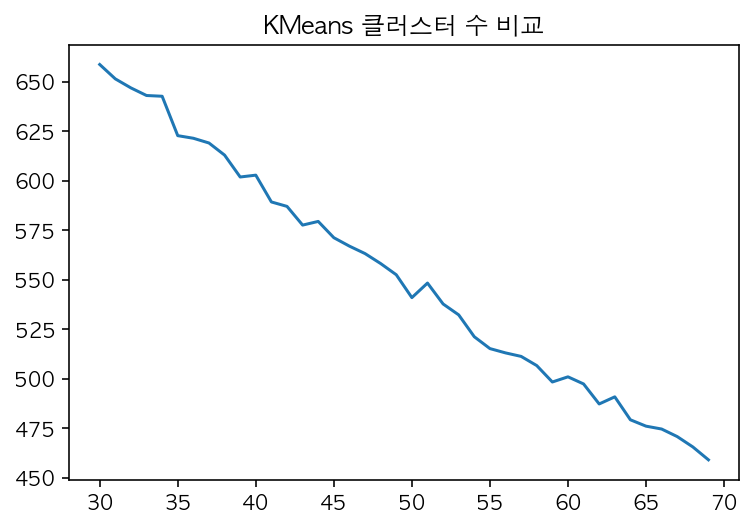

In [37]:
plt.plot(range(start, end), inertia)
plt.title("KMeans 클러스터 수 비교")

In [38]:
n_clusters = 50
cls = KMeans(n_clusters=n_clusters, random_state=42)
cls.fit(feature_tfidf)
prediction = cls.predict(feature_tfidf)
df["cluster"] = prediction

In [39]:
df["cluster"].value_counts().head(10)

0     1302
5       39
4       36
2       30
7       26
1       24
26      23
9       22
11      20
22      18
Name: cluster, dtype: int64

In [40]:
# batch_size 를 쓸 수 있는 MiniBatchKMeans 로 군집화
from sklearn.cluster import MiniBatchKMeans
b_inertia = []

# 적절한 클러스터의 갯수를 알기 위해 inertia 값을 구함
for i in trange(start, end):
    cls = MiniBatchKMeans(n_clusters=i, random_state=42)
    cls.fit(feature_tfidf)
    b_inertia.append(cls.inertia_)

100%|██████████| 40/40 [00:17<00:00,  1.18s/it]


Text(0.5, 1.0, 'MiniBatchKMeans 클러스터 수 비교')

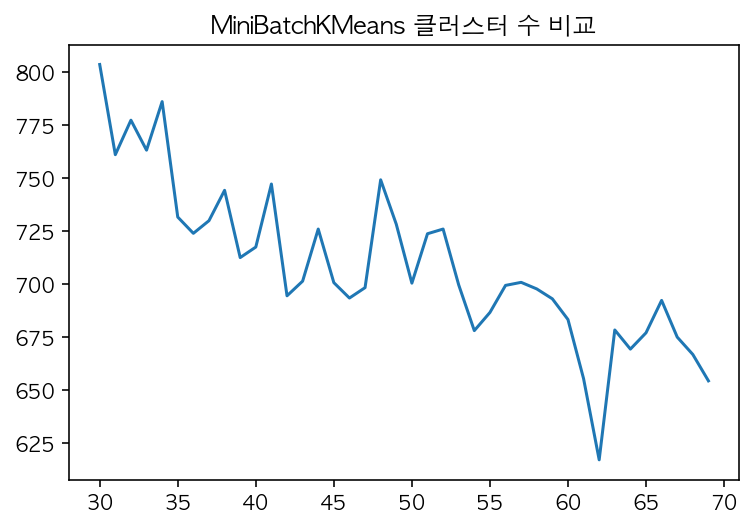

In [41]:
plt.plot(range(start, end), b_inertia)
plt.title("MiniBatchKMeans 클러스터 수 비교")

In [42]:
cls = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
cls.fit(feature_tfidf)
prediction = cls.predict(feature_tfidf)
df["bcluster"] = prediction

In [43]:
df["bcluster"].value_counts().head(10)

20    932
3     360
2      60
13     39
1      36
17     33
12     33
14     30
28     30
4      26
Name: bcluster, dtype: int64

In [44]:
df.loc[df["bcluster"] == 21, "course"].value_counts().head(1)

Series([], Name: course, dtype: int64)

In [45]:
df.loc[df["bcluster"] == 21, ["bcluster", "cluster", "course"]]

,bcluster,cluster,course


In [46]:
df.loc[df["bcluster"] == 24, ["bcluster", "cluster", "origin_text", "course"]].tail(10)

,bcluster,cluster,origin_text,course
65,24,27,데이터 분석을 끝내고 싶다.\n#관심과목: SQL/DB(MySQL) 기본부터 파이썬...,데이터 분석을 끝내고 싶다.\n#관심과목 sql/db(mysql) 기본부터 파이썬/...
394,24,27,사람들이 무슨 생각을 하는지 알고 싶네요.\n관심강의는 SQL/DB(MySQL) 기...,는 sql/db(mysql) 기본부터 파이썬/데이터분석 활용까지 입니다.
474,24,27,데이터분석가로 취직하기 위해서 SQL 시작하고 파이썬 마스터하고 싶습니다!\n관심강...,"sql/db(mysql) 기본부터 파이썬/데이터분석 활용까지!,\n남박사의 파이썬..."
547,24,27,SQL/DB(MySQL) 기본부터 파이썬/데이터분석 활용까지!\n\n이 강의 꼭 듣...,sql/db(mysql) 기본부터 파이썬/데이터분석 활용까지!\n\n이 강의 꼭 듣...
566,24,27,빅데이터 분석을 공부해서 올해 취직을 목표로 하고있습니다! 첫 사회생활 한다니까 너...,- sql/db(mysql)기본부터 파이썬/데이터분석 활용까지!
1581,24,27,파이썬관련하여 공부를 더 열심히 하고 싶어요!\n관심 강의 : SQL/DB(MySQ...,sql/db(mysql) 기본부터 파이썬/데이터분석 활용까지!
1593,24,27,파이썬을 이용한 데이터분석에 관심이 생겨서 공부하려고 합니다. 목표를 꼭 달성했으면...,sql/db(mysql) 기본부터 파이썬/데이터분석 활용까지!


### 클러스터 예측 정확도 확인하기

In [47]:
# n_clusters 위에서 정의한 클러스터 수를 사용
feature_array = feature_vector.toarray()
# 예측한 클러스터의 유니크 값
labels = np.unique(prediction)
df_cluster_score = []
df_cluster = []
for label in labels:
    id_temp = np.where(prediction==label) # 예측한 값이 클러스터 번호와 매치 되는 것을 가져옴
    x_means = np.mean(feature_array[id_temp], axis = 0) # 클러스터의 평균 값을 구함
    sorted_means = np.argsort(x_means)[::-1][:n_clusters] # 값을 역순으로 정렬해서 클러스터 수 만큼 가져옴
    features = vectorizer.get_feature_names()
    best_features = [(features[i], x_means[i]) for i in sorted_means] 
    # 클러스터별 전체 스코어
    df_score = pd.DataFrame(best_features, columns = ['features', 'score'])
    df_cluster_score.append(df_score)
    # 클러스터 대표 키워드
    df_cluster.append(best_features[0])

In [48]:
np.argsort(x_means)[::-1]

array([1734, 1934,  635, ..., 1295, 1296,    0])

In [49]:
# 개별 클러스터에서 점수가 가장 높은 단어를 추출 아래 점수가 클수록 예측 정확도가 높음
# MiniBatchKMeans 로 예측한 값 기준
pd.DataFrame(df_cluster, columns = ['features', 'score']).sort_values(by=["features", "score"], ascending=False)

,features,score
1,홍정모의 따라하며 배우는,1.000000
12,홍정모의 따라하며 배우는,0.393939
4,함수형 프로그래밍과 자바스크립트,1.115385
2,프로그래밍 시작하기 파이썬 입문,0.200000
41,파이썬 알고리즘 문제풀이,1.000000
16,파이썬 알고리즘 문제풀이,0.526316
14,파이썬 머신러닝 완벽가이드,0.366667
13,파이썬 머신러닝 완벽,1.000000
36,테스트주도개발 tdd 만드는 nodejs api,1.000000
21,취업을 위한 알고리즘 입문 with 창의적,1.000000


In [50]:
# 정확도가 1이 나온 클러스터를 찾아봄 - 같은 강좌끼리 묶였는지 확인 함
df.loc[df["bcluster"] == 32, ["bcluster", "cluster", "origin_text", "course"]]

,bcluster,cluster,origin_text,course
1257,32,0,얼마전 취업한 초급 개발자 입니다.\n현재 열시미 파이썬을 공부중이에요!\n#관심강...,처음 시작하는 파이썬
1268,32,0,비전공자이지만 시대의 흐름에 뒤쳐지지 않기 위해 프로그래밍 공부를 하고 싶습니다. ...,처음 시작하는 파이썬


## WordCloud
* [amueller/word_cloud: A little word cloud generator in Python](https://github.com/amueller/word_cloud)
* 설치 방법 : [Wordcloud :: Anaconda Cloud](https://anaconda.org/conda-forge/wordcloud)

In [51]:
from wordcloud import WordCloud

# 불용어 - 자주 등장하지만 의미가 크지 않아 제외하고 싶은 텍스트
stopwords = ["관심 강의", "관심강의", "관심", "강의", "강좌", "강의를",
             "올해", "올해는", "열심히", "공부를", "합니다", "하고", "싶어요", 
             "있는", "있습니다", "싶습니다", "2020년"]
# 불용어를 제거하지 않고 그리려면 아래 주석을 풀어서 stopword 변수에 덮어쓰기를 합니다.
# stopwords = []
def displayWordCloud(data = None, backgroundcolor = 'black', width=1280, height=768):
    wordcloud = WordCloud(
                        font_path = '/Library/Fonts/NanumBarunGothic.ttf', 
                        stopwords = stopwords, 
                        background_color = backgroundcolor, 
                        width = width, height = height, 
                        random_state=42).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show() 

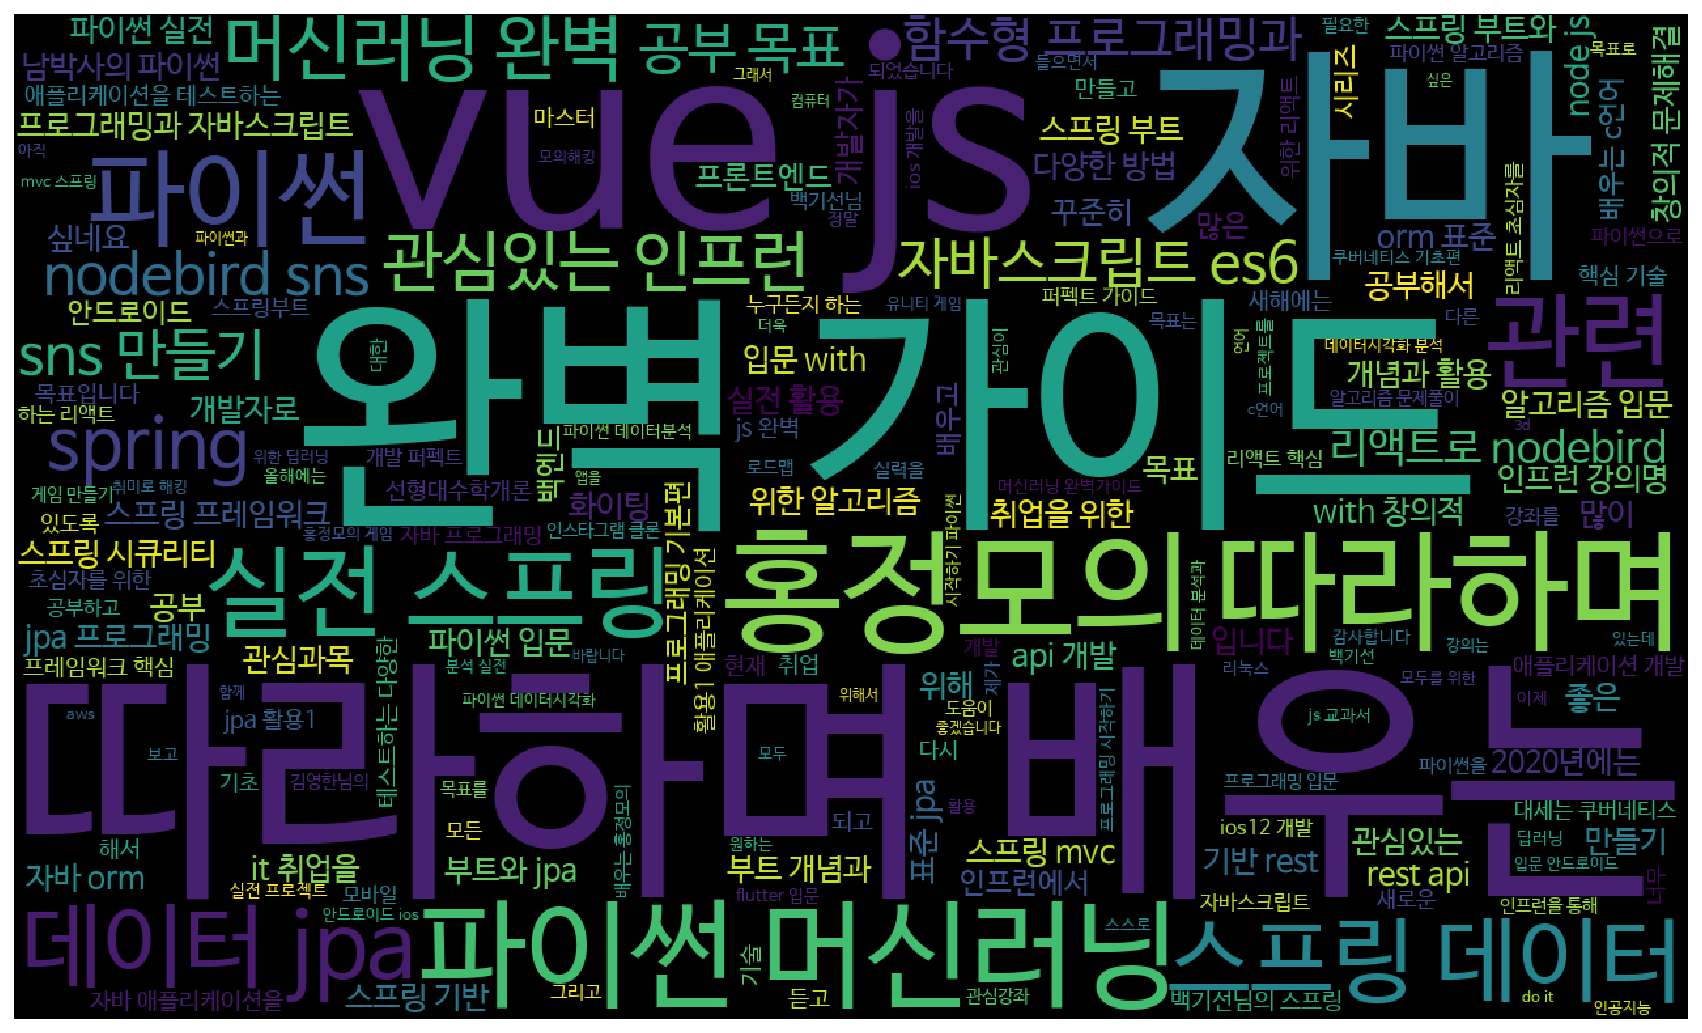

In [52]:
course_text = " ".join(df["course"])
displayWordCloud(course_text)